In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd
from sklearn import datasets

# Problem 1

In this problem we will look at image compression using SVD, following the lines of the well-known "Eigenfaces" experiment. The basic concept is to represent an image (in grayscale) of size $m \times n$ as an $m \times n$ real matrix $M$. SVD is then applied to this matrix to obtain $U$, $S$, and $V$ such that $M = U S V^T$. Here $U$ and $V$ are the matrices whose columns are the left and right singular vectors respectively, and $S$ is a diagonal $m \times n$ matrix consisting of the singular values of $M$. The number of non-zero singular values is the rank of $M$. By using just the largest $k$ singular values (and corresponding left and right singular vectors), one obtains the best rank-$k$ approximation to $M$.

The following code returns the dataset of 400 images.

In [ ]:
data = datasets.fetch_olivetti_faces()
images = data.images # Shape (400, 64, 64), 400 images of size 64x64

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


(a) Given an $m \times n$ image $M$ and its rank-$k$ approximation $A$, we can measure the reconstruction error using mean $\ell_1$ error: $$ \text{error}_{\ell_1}(M, A) = \frac{1}{mn}\| M - A \|_1 = \frac{1}{mn}\sum_{i=1}^{m}\sum_{j=1}^{n}| M_{i,j} - A_{i,j} |. $$ For $k = 1, \dots, 30$, take the average rank-$k$ reconstruction error over all images in the dataset, and plot a curve of average reconstruction error as a function of $k$.

In [ ]:
# Returns the best rank-k approximation to M
def svd_reconstruct(M, k):
    # Advice: pass in full_matrices=False to svd to avoid dimensionality issues
    """
    Returns the best rank-k approximation of the image matrix M using SVD.
    """
    U, S, Vt = svd(M, full_matrices=False) #M = mxn real matrix
    S_k = np.diag(S[:k])  # kxk diagonal matrix, top-k singular values from S
    U_k = U[:, :k]  # mxk orthogonal matrix, Take first k columns of U
    Vt_k = Vt[:k, :]  # kxn orthogonal matrix, Take first k rows of Vt

    return np.dot(U_k, np.dot(S_k, Vt_k)) #redefined M = Uk*Sk*VtK

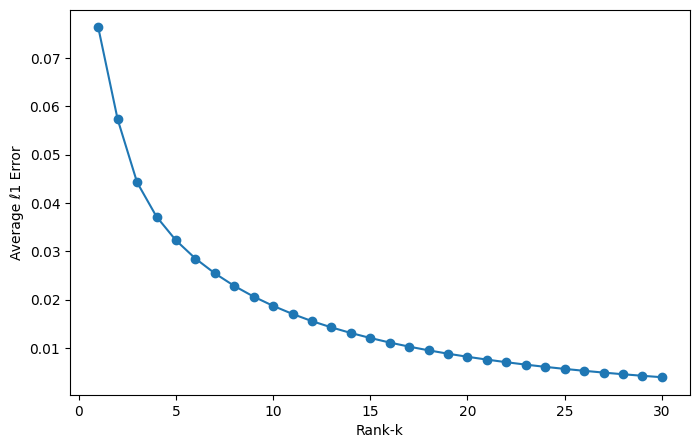

In [ ]:
# Initiate values
k_values = range(1, 31)
errors = []

# Compute average error for each k
for k in k_values:
    total_error = 0
    for img in images:
        A_k = svd_reconstruct(img, k)
        total_error += np.sum(np.abs(img - A_k))/(img.shape[0]*img.shape[1]) # avg l1 error per image = summations |Mij-Aij|
    # avg l1 error for all images (400)= avg l1 error per image/400 images
    errors.append(total_error/len(images))

# Plot error vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, errors, marker='o')
plt.xlabel('Rank-k')
plt.ylabel('Average ℓ1 Error')
plt.show()

(b) Pick any image in the dataset, and display the following side-by-side as images: the original, and the best rank-$k$ approximations for $k = 10, 20, 30, 40$. You will find the `imshow` method in matplotlib useful for this; pass in `cmap='gray'` to render in grayscale. Feel free to play around further.

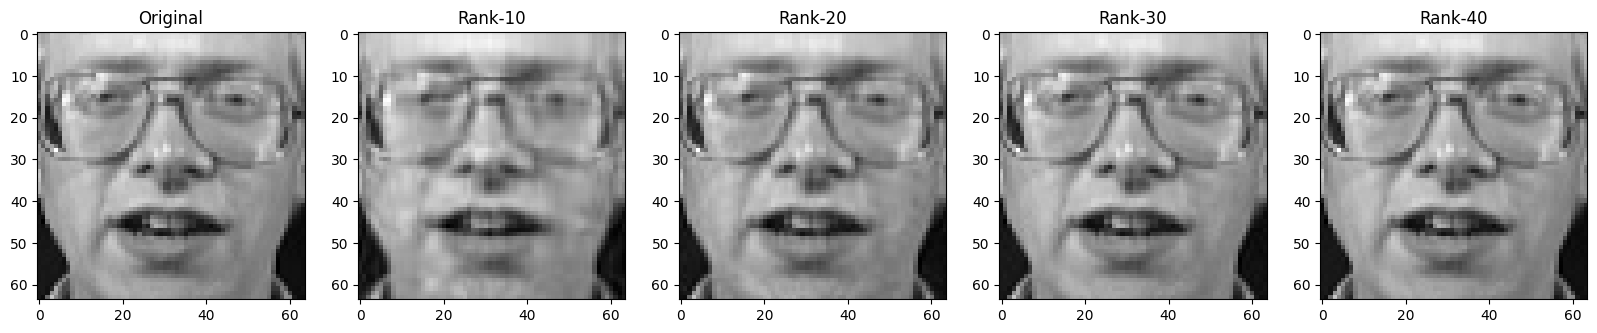

In [ ]:
import random

# Initiate values
image = images[random.randint(0, len(images) - 1)] # Pick a random image #
k_values2 = [10,20,30,40]

# Display original and rank-k approximations
fig, axes = plt.subplots(1, len(k_values2) + 1, figsize=(20,10)) # subplots(display images in single row, [original image, k=10, k=20, k=30, k=40])
axes[0].imshow(image, cmap='gray') #display (original) data as an image in 1st column
axes[0].set_title("Original")

for i, k in enumerate(k_values2):
    M_k = svd_reconstruct(image, k) # applies SVD & reconstructs 'image' using the top k singular values
    axes[i + 1].imshow(M_k, cmap='gray') # display redefined M using top k singular values
    axes[i + 1].set_title(f"Rank-{k}")

plt.show()

# Problem 2

In this problem we visualize the Wisconsin breast cancer dataset in two dimensions using PCA. First, rescale the data so that every feature has mean 0 and standard deviation 1 across the various points in the dataset. You may find `sklearn.preprocessing.StandardScaler` useful for this. Next, compute the top two principal components of the dataset using PCA, and for every data point, compute its coordinates (i.e. projections) along these two principal components. You should do this in two ways:
1. By using SVD directly. Do not use any PCA built-ins.
2. By using `sklearn.decomposition.PCA`.

The two approaches should give exactly the same result, and this also acts as a check. (But note that the signs of the singular vectors may be flipped in the two approaches since singular vectors are only determined uniquely up to sign. If this happens, flip signs to make everything identical again.)

Your final goal is to make a scatterplot of the dataset in 2 dimensions, where the x-axis is the first principal component and the y-axis is the second. Color the points by their diagnosis (malignant or benign). Do this for both approaches. Your plots should be identical. Does the data look roughly separable already in 2 dimensions?

In [2]:
cancer = datasets.load_breast_cancer()

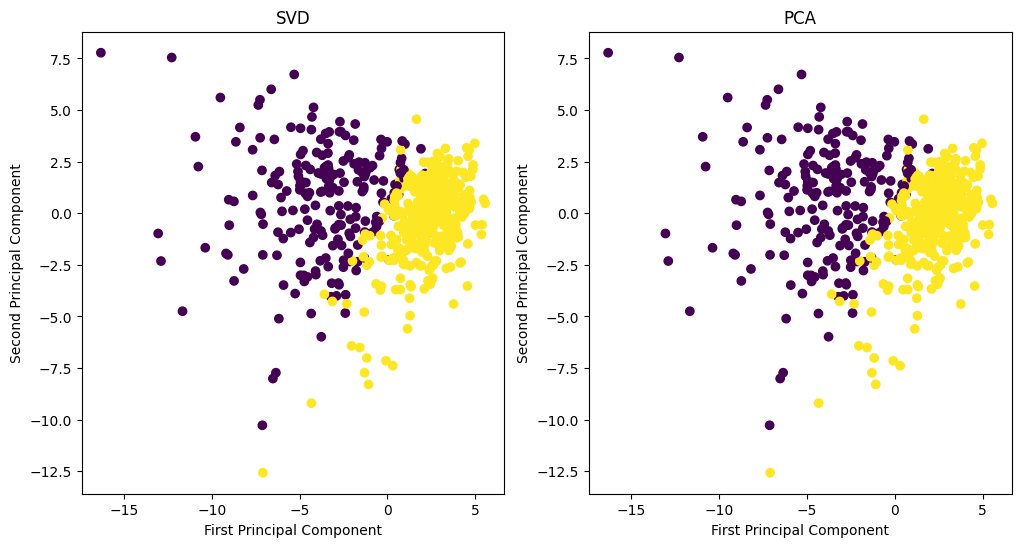

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X,y = cancer.data, cancer.target

# Rescale data so every features has mean 0 and std dev 1
X_rescale = StandardScaler().fit_transform(X)

# Compute top 2 principal components of the dataset using PCA, and for every data point, compute its coordinates (i.e. projections)
# 1. SVD
U, s, Vt = svd(X_rescale, full_matrices=False)
S = np.zeros((X_rescale.shape[0], X_rescale.shape[1]))
S[:X_rescale.shape[1], :X_rescale.shape[1]] = np.diag(s)
X_svd = np.dot(X_rescale, (Vt[:2]).T) # Top 2 principal components = first 2 rows of Vt = (Vt[:2])
# 2. PCA
X_pca = PCA(n_components=2).fit_transform(X_rescale)

# Adjusting the sign to match Mathod 1 with 2
if np.sum(X_svd[:,0] * X_pca[:,0]) < 0 :
    X_pca[:,0] *= -1
if np.sum(X_svd[:,1] * X_pca[:,1]) < 0 :
    X_pca[:,1] *= -1

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y)
plt.title("SVD")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.title("PCA")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

plt.show()